In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Data importing and cleaning

## Scores

In [3]:
# load patient information
patients = pd.read_csv('../data/raw/scores.csv')
patients.set_index('number', inplace=True)

# infer condition vs. control
patients['condition'] = patients.index.str.startswith('condition').astype(int)

# convert binary columns to standard representation (1=True, 2=False)
binary = ['gender', 'melanch', 'inpatient', 'marriage', 'work']
patients[binary] = patients[binary].astype('Int64')
patients.loc[:,binary] = patients.loc[:,binary].replace(2, 0)

# convert afftype column to integer
patients['afftype'] = patients['afftype'].astype('Int64')

# inspect
print(patients.shape)
patients.head()

(55, 12)


days  gender    age  afftype  melanch  inpatient    edu  \
number                                                                 
condition_1    11       0  35-39        2        0          0   6-10   
condition_2    18       0  40-44        1        0          0   6-10   
condition_3    13       1  45-49        2        0          0   6-10   
condition_4    13       0  25-29        2        0          0  11-15   
condition_5    13       0  50-54        2        0          0  11-15   

             marriage  work  madrs1  madrs2  condition  
number                                                  
condition_1         1     0    19.0    19.0          1  
condition_2         0     0    24.0    11.0          1  
condition_3         0     0    24.0    25.0          1  
condition_4         1     1    20.0    16.0          1  
condition_5         0     0    26.0    26.0          1

In [4]:
patients.info()  

<class 'pandas.core.frame.DataFrame'>
Index: 55 entries, condition_1 to control_32
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   days       55 non-null     int64  
 1   gender     55 non-null     Int64  
 2   age        55 non-null     object 
 3   afftype    23 non-null     Int64  
 4   melanch    20 non-null     Int64  
 5   inpatient  23 non-null     Int64  
 6   edu        53 non-null     object 
 7   marriage   23 non-null     Int64  
 8   work       23 non-null     Int64  
 9   madrs1     23 non-null     float64
 10  madrs2     23 non-null     float64
 11  condition  55 non-null     int64  
dtypes: Int64(6), float64(2), int64(2), object(2)
memory usage: 5.9+ KB


In [5]:
# check out the object-typed columns
print(patients.age.unique())
print(patients.edu.unique())

['35-39' '40-44' '45-49' '25-29' '50-54' '20-24' '60-64' '55-59' '30-34'
 '65-69']
['6-10' '11-15' '16-20' ' ' nan]


In [6]:
# replace empty values with NaN
patients.edu.replace(' ', np.nan, inplace=True)

In [7]:
patients[patients['condition']==1].isna().sum()

days         0
gender       0
age          0
afftype      0
melanch      3
inpatient    0
edu          1
marriage     0
work         0
madrs1       0
madrs2       0
condition    0
dtype: int64

In [8]:
patients[patients['condition']==0].isna().sum()

days          0
gender        0
age           0
afftype      32
melanch      32
inpatient    32
edu          32
marriage     32
work         32
madrs1       32
madrs2       32
condition     0
dtype: int64

In total, we have 4 rows with missing values for the condition patients (3 missing melancholy values and 1 missing education value). For the control patients, demographic information is limited to gender and age only.

## Activity data

In [9]:
def process_activity(df):
    out = df[['timestamp', 'activity']].copy(deep=True)
    out.timestamp = pd.to_datetime(out.timestamp)
    out['date'] = out.timestamp.dt.date
    return out

activity = {}

condition_path = '../data/raw/condition/'
for filename in os.listdir(condition_path):
    activity[filename[:-4]] = process_activity(pd.read_csv(condition_path + filename))

control_path = '../data/raw/control/'
for filename in os.listdir(control_path):
    activity[filename[:-4]] = process_activity(pd.read_csv(control_path + filename))

print(len(activity))

55


In [10]:
act = activity['condition_1']
act.head()

timestamp  activity        date
0 2003-05-07 12:00:00         0  2003-05-07
1 2003-05-07 12:01:00       143  2003-05-07
2 2003-05-07 12:02:00         0  2003-05-07
3 2003-05-07 12:03:00        20  2003-05-07
4 2003-05-07 12:04:00       166  2003-05-07

In [11]:
# check for missing rows

def missed_rows(df):
    # Sort the dataframe by the timestamp column
    df.sort_values(by='timestamp', inplace=True)
    
    # Calculate the time difference between consecutive timestamps
    time_diff = df['timestamp'].diff().dt.total_seconds() / 60
    
    # Check if there are any gaps in consecutive minutes
    gaps = time_diff > 1

    # Count the number of missed minutes
    num_missed_minutes = int(time_diff[gaps].sum() - gaps.sum())
    
    return num_missed_minutes, gaps

total_missed_rows = {}
for k in activity:
    total_missed_rows[k], gaps = missed_rows(activity[k])
    if total_missed_rows[k] > 0:
        print(f"Table {k}, total missed rows: {total_missed_rows[k]}")
        print(activity[k].loc[gaps, 'timestamp'])
        print()
    # start_time = activity[k].timestamp.min()
    # end_time = activity[k].timestamp.max()
    # if start_time.hour != 0:
    #     print(f"Table {k}, non-standard starting time: {str(start_time)}")
    #     print()
              


Table control_6, total missed rows: 60
16500   2003-03-30 03:00:00
Name: timestamp, dtype: datetime64[ns]

Table control_7, total missed rows: 60
16500   2003-03-30 03:00:00
Name: timestamp, dtype: datetime64[ns]

Table control_31, total missed rows: 60
16500   2003-03-30 03:00:00
Name: timestamp, dtype: datetime64[ns]

Table control_32, total missed rows: 60
16500   2003-03-30 03:00:00
Name: timestamp, dtype: datetime64[ns]

Table control_1, total missed rows: 60
16500   2003-03-30 03:00:00
Name: timestamp, dtype: datetime64[ns]



It looks like in some of the tables, we are missing exactly one hour of data on the night of 30th of March. While it is not clear in which country the study took place, I think it is fair to conclude that this missing data has to do with the changing of the clock at the end of daylight savings period.

In [12]:
# check for days with very low activity

def find_suspicious_days(threshold):
    suspicious_days = []

    for k in activity:
        act = activity[k]
        mean_daily_act = act.groupby('date').agg({'activity': 'mean'})
        for sus_day in mean_daily_act.query('activity <= @threshold').index:
            suspicious_days.append((k, sus_day, mean_daily_act.activity[sus_day]))  

    suspicious_days.sort(key = lambda x: x[2])
    suspicious_days = suspicious_days[::-1]
    return suspicious_days

Found 270 days with suspiciously low activity


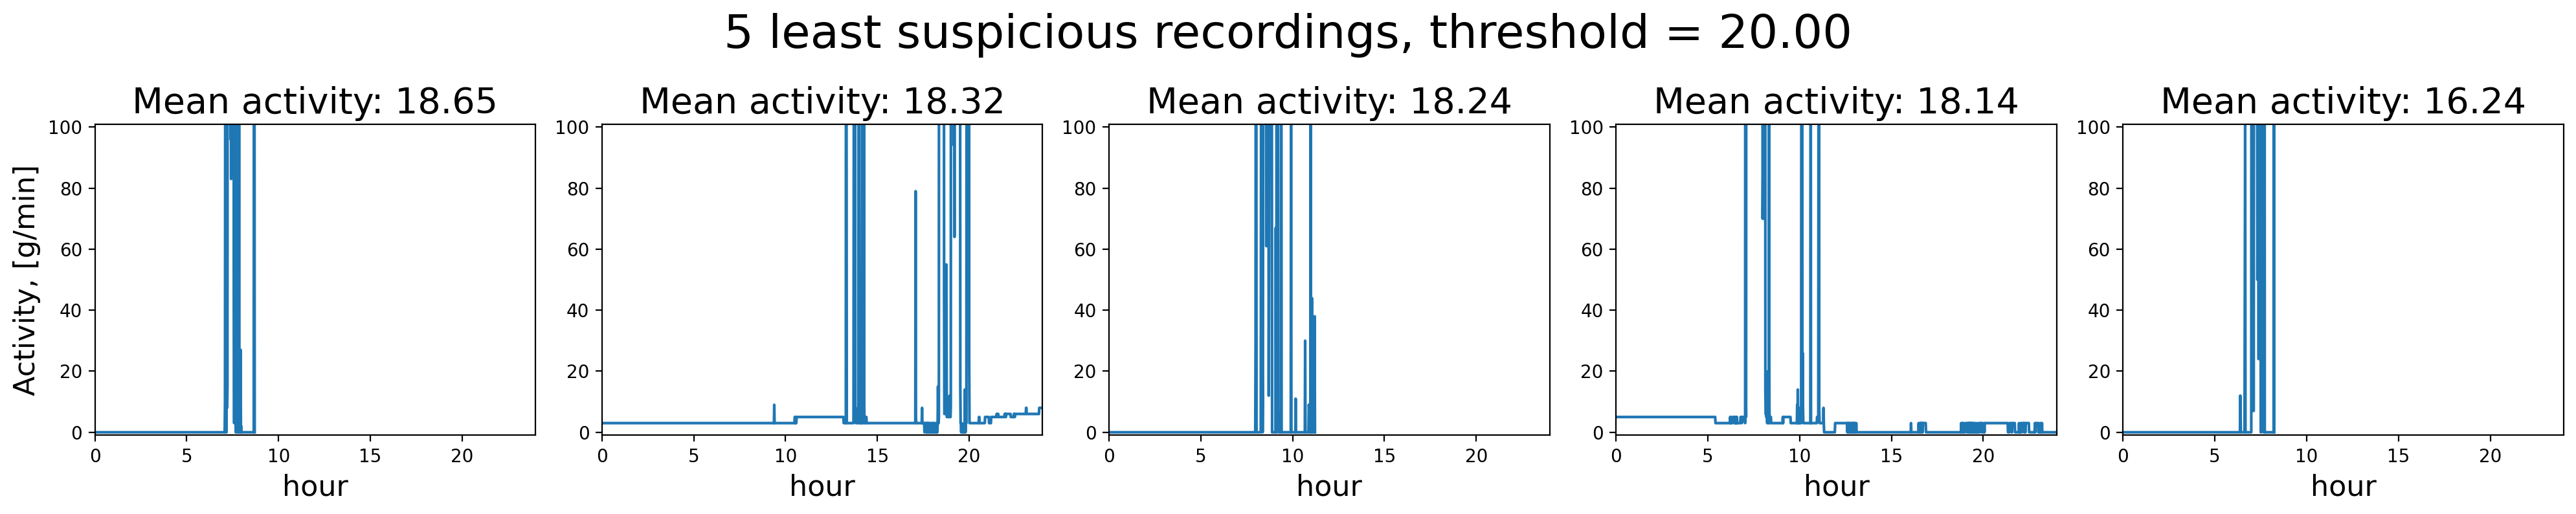

In [27]:
    
def plot_least_suspicious_days(threshold):
    suspicious_days = find_suspicious_days(threshold)
    print(f'Found {len(suspicious_days)} days with suspiciously low activity')

    plt.figure(figsize=(20,4), dpi=200)
    for i in range(min(5, len(suspicious_days))):
        plt.subplot(1,5,i+1)
        patient = suspicious_days[i][0]
        date = suspicious_days[i][1]
        act_data = activity[patient].query('date == @date')
        act_data.sort_values(by='date')
        xaxis = pd.to_timedelta(act_data.timestamp.dt.time.astype(str)).dt.total_seconds() / (60*60)
        plt.plot(xaxis,act_data.activity),
        plt.xlabel("hour", fontsize=16)
        if i == 0:
            plt.ylabel('Activity, [g/min]', fontsize=16)
        plt.xlim(left=0, right=24)
        plt.ylim(-1,101)
        plt.title(f"Mean activity: {suspicious_days[i][2]:.2f}", fontsize=20)
    plt.suptitle(f"5 least suspicious recordings, threshold = {threshold:.2f}", fontsize=26)
    plt.tight_layout()
    plt.show()

plot_least_suspicious_days(20)

Found 305 days with suspiciously low activity


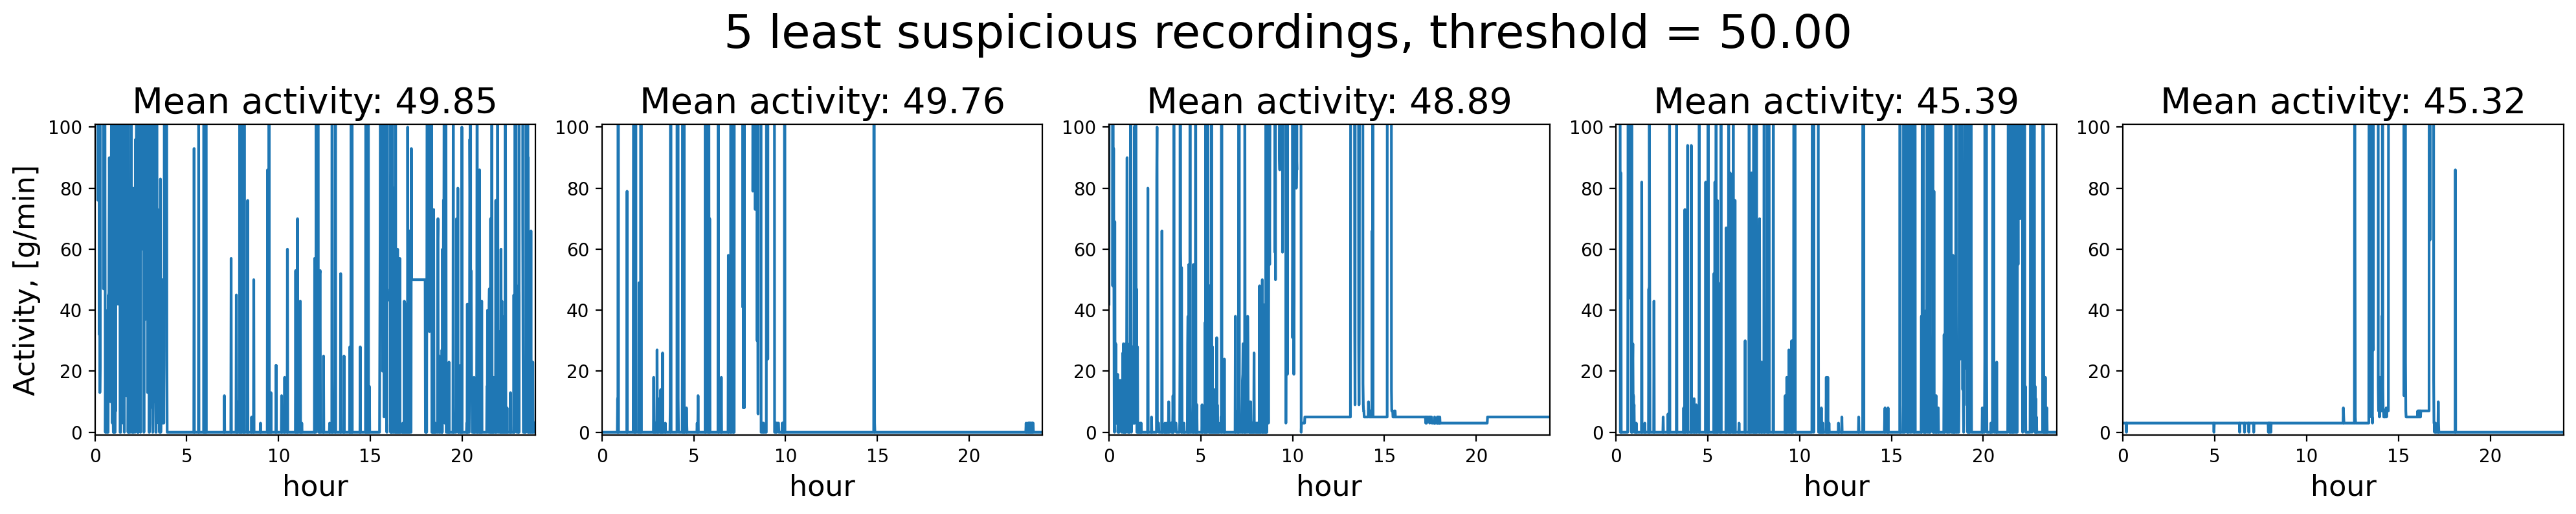

In [28]:
plot_least_suspicious_days(50)

In [29]:
# Discarding suspicious days

threshold = 20
suspicious_days = find_suspicious_days(threshold)
for patient, date, _ in suspicious_days:
    # patients.loc[patient, 'days'] = patients.loc[patient, 'days'] - 1
    activity[patient] = activity[patient].query('date != @date')
    
threshold = 20
suspicious_days = find_suspicious_days(threshold)
print(f'Found {len(suspicious_days)} days with suspiciously low activity')

Found 0 days with suspiciously low activity


# Exploratory analysis of the dataset

At this point, we have:
- `patients` — table with patient info
- `activity` — dict with tables containing activity data

In [30]:
patients.head()

days  gender    age  afftype  melanch  inpatient    edu  \
number                                                                 
condition_1    11       0  35-39        2        0          0   6-10   
condition_2    18       0  40-44        1        0          0   6-10   
condition_3    13       1  45-49        2        0          0   6-10   
condition_4    13       0  25-29        2        0          0  11-15   
condition_5    13       0  50-54        2        0          0  11-15   

             marriage  work  madrs1  madrs2  condition  
number                                                  
condition_1         1     0    19.0    19.0          1  
condition_2         0     0    24.0    11.0          1  
condition_3         0     0    24.0    25.0          1  
condition_4         1     1    20.0    16.0          1  
condition_5         0     0    26.0    26.0          1

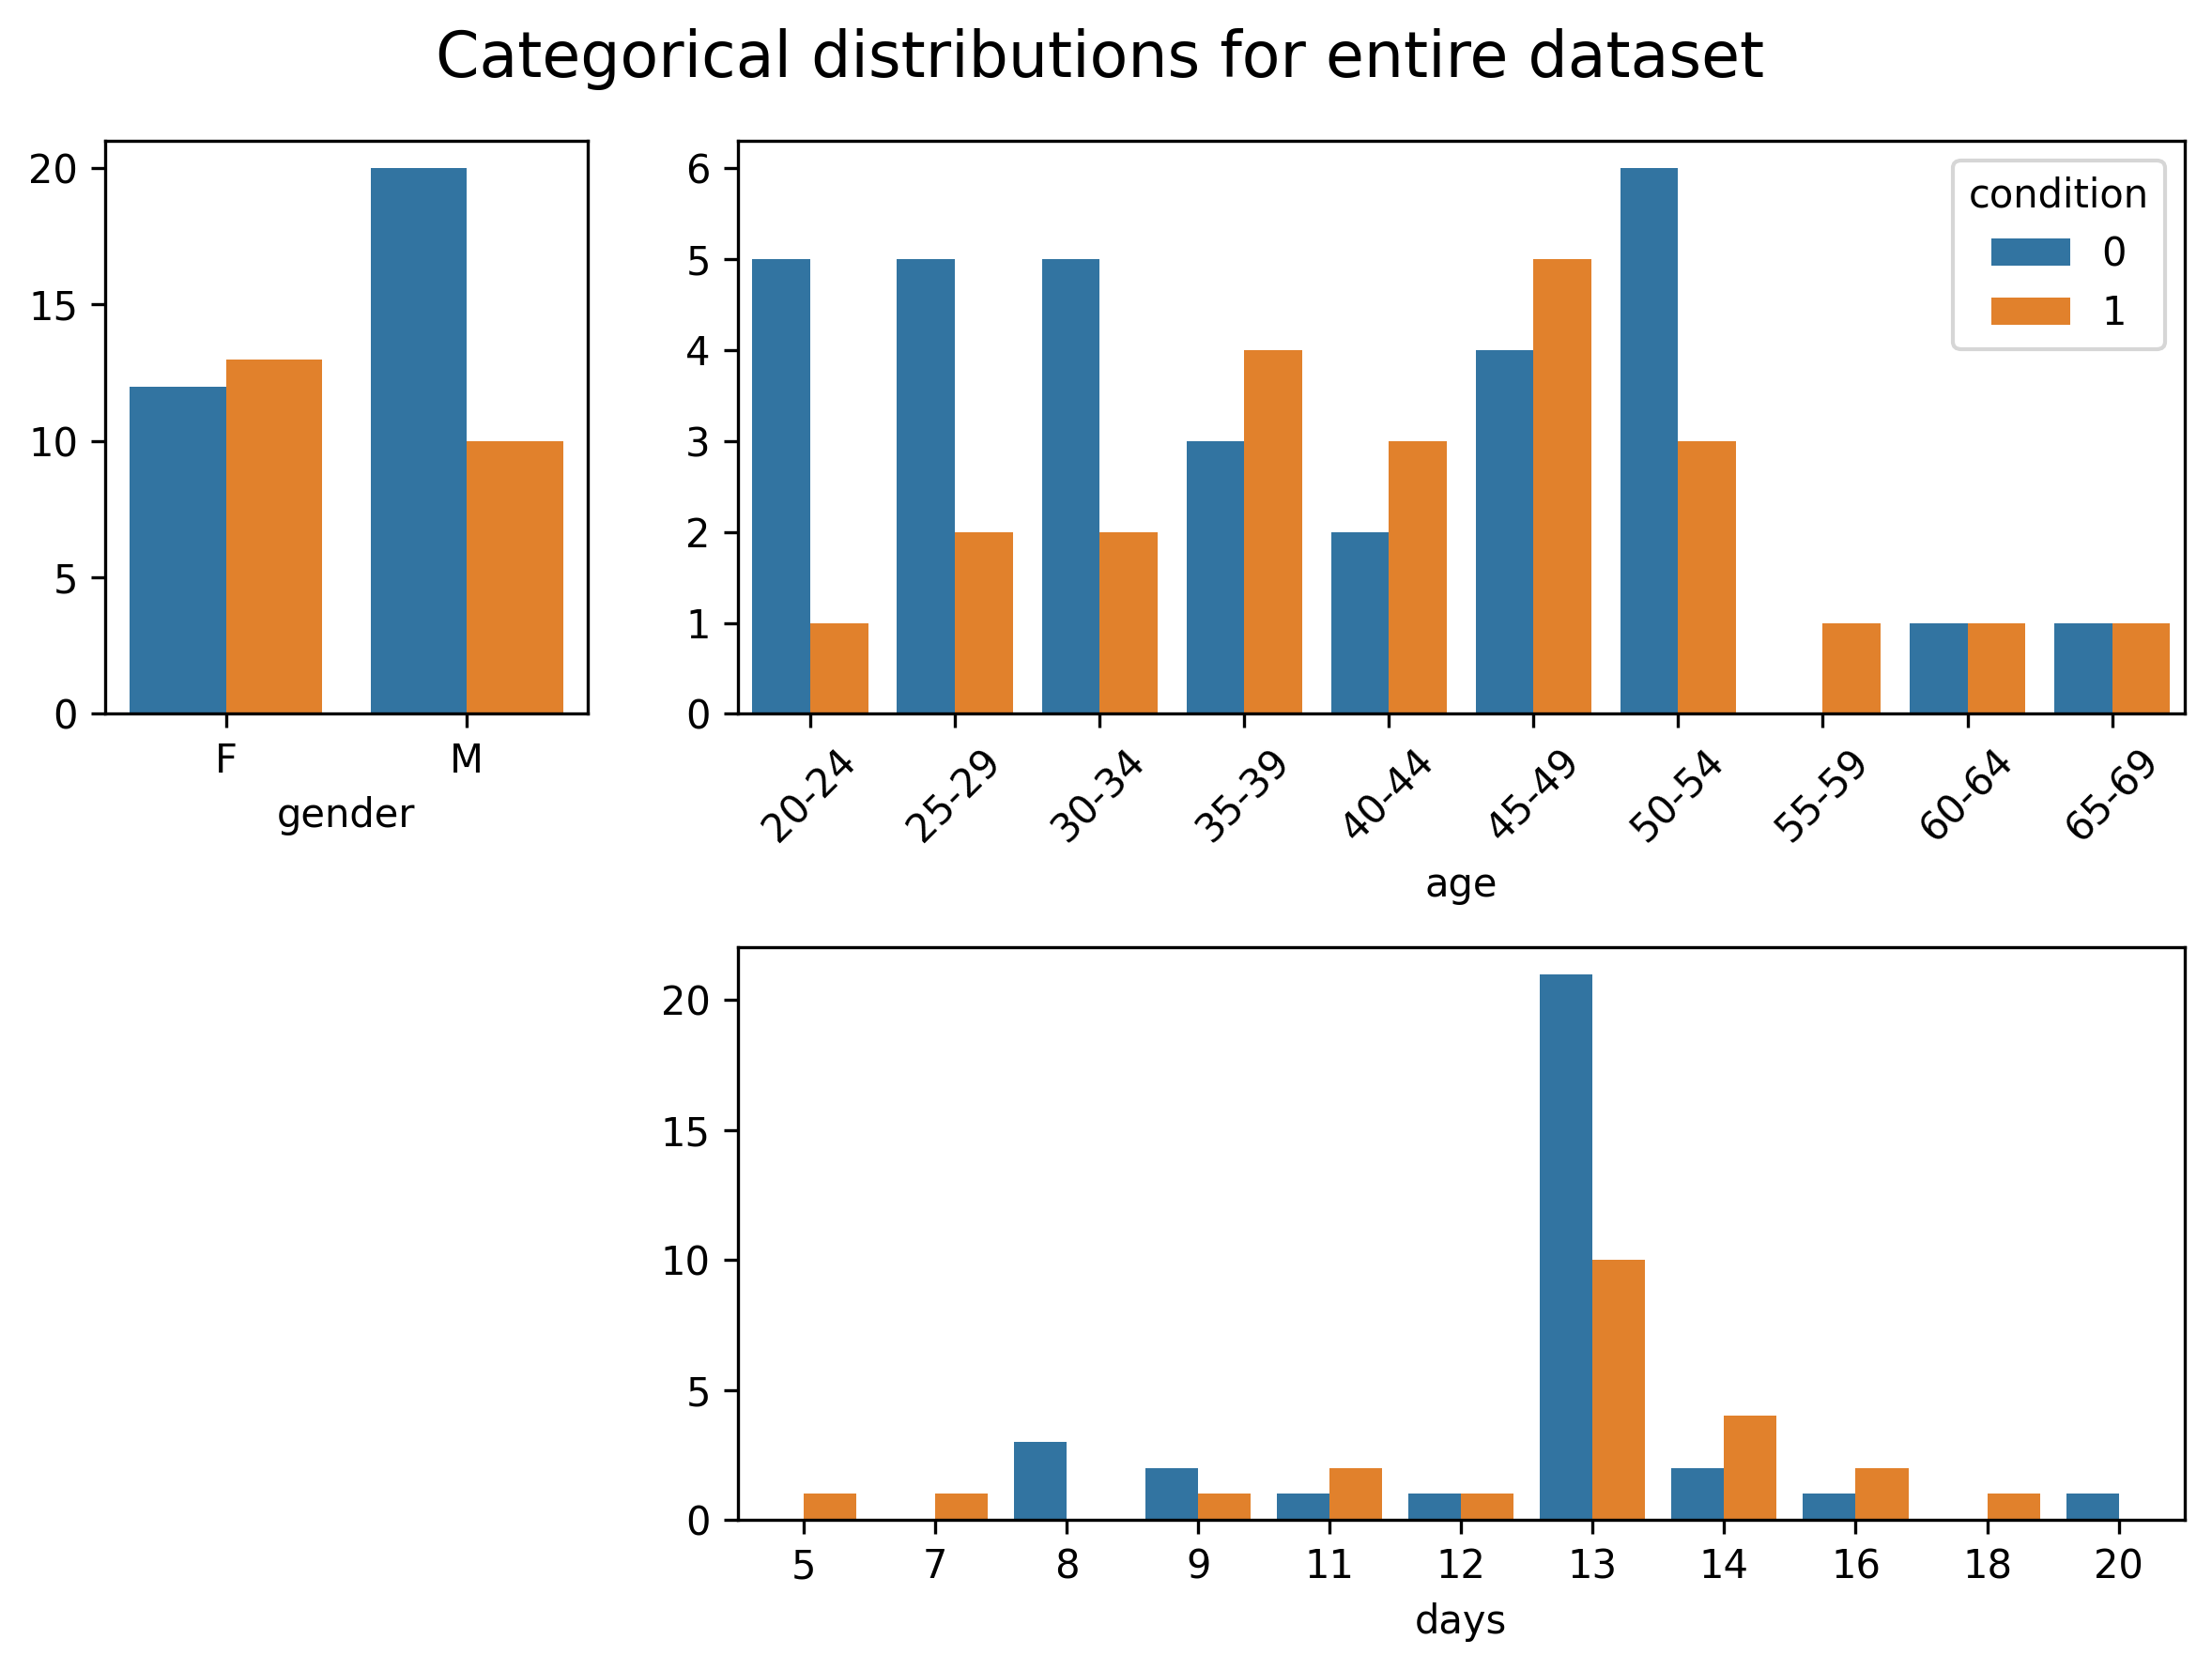

In [31]:
# Univariate distributions across entire dataset (where applicable)

labels = ['not depressed', 'depressed']
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8,6), width_ratios=[1,3], dpi=300)
# for i, cat in enumerate(general_categorical):

sns.countplot(data=patients, x='gender', hue='condition', legend=False, ax=ax1)
ax1.set_ylabel('')
ax1.set_xticks([0,1], labels=['F', 'M'])
# ax1.legend(labels=['M', 'F'])

sns.countplot(data=patients, x='age', hue='condition', order=sorted(patients.age.unique()), legend=True, ax=ax2)
ax2.tick_params(axis='x', labelrotation=45)
ax2.set_ylabel('')

sns.countplot(data=patients, x='days', hue='condition',  legend=False, ax=ax4)
ax4.set_ylabel('')
plt.setp(ax4.patches, linewidth=0)

plt.suptitle('Categorical distributions for entire dataset', fontsize=16)
plt.tight_layout()

plt.delaxes(ax3)
plt.show()

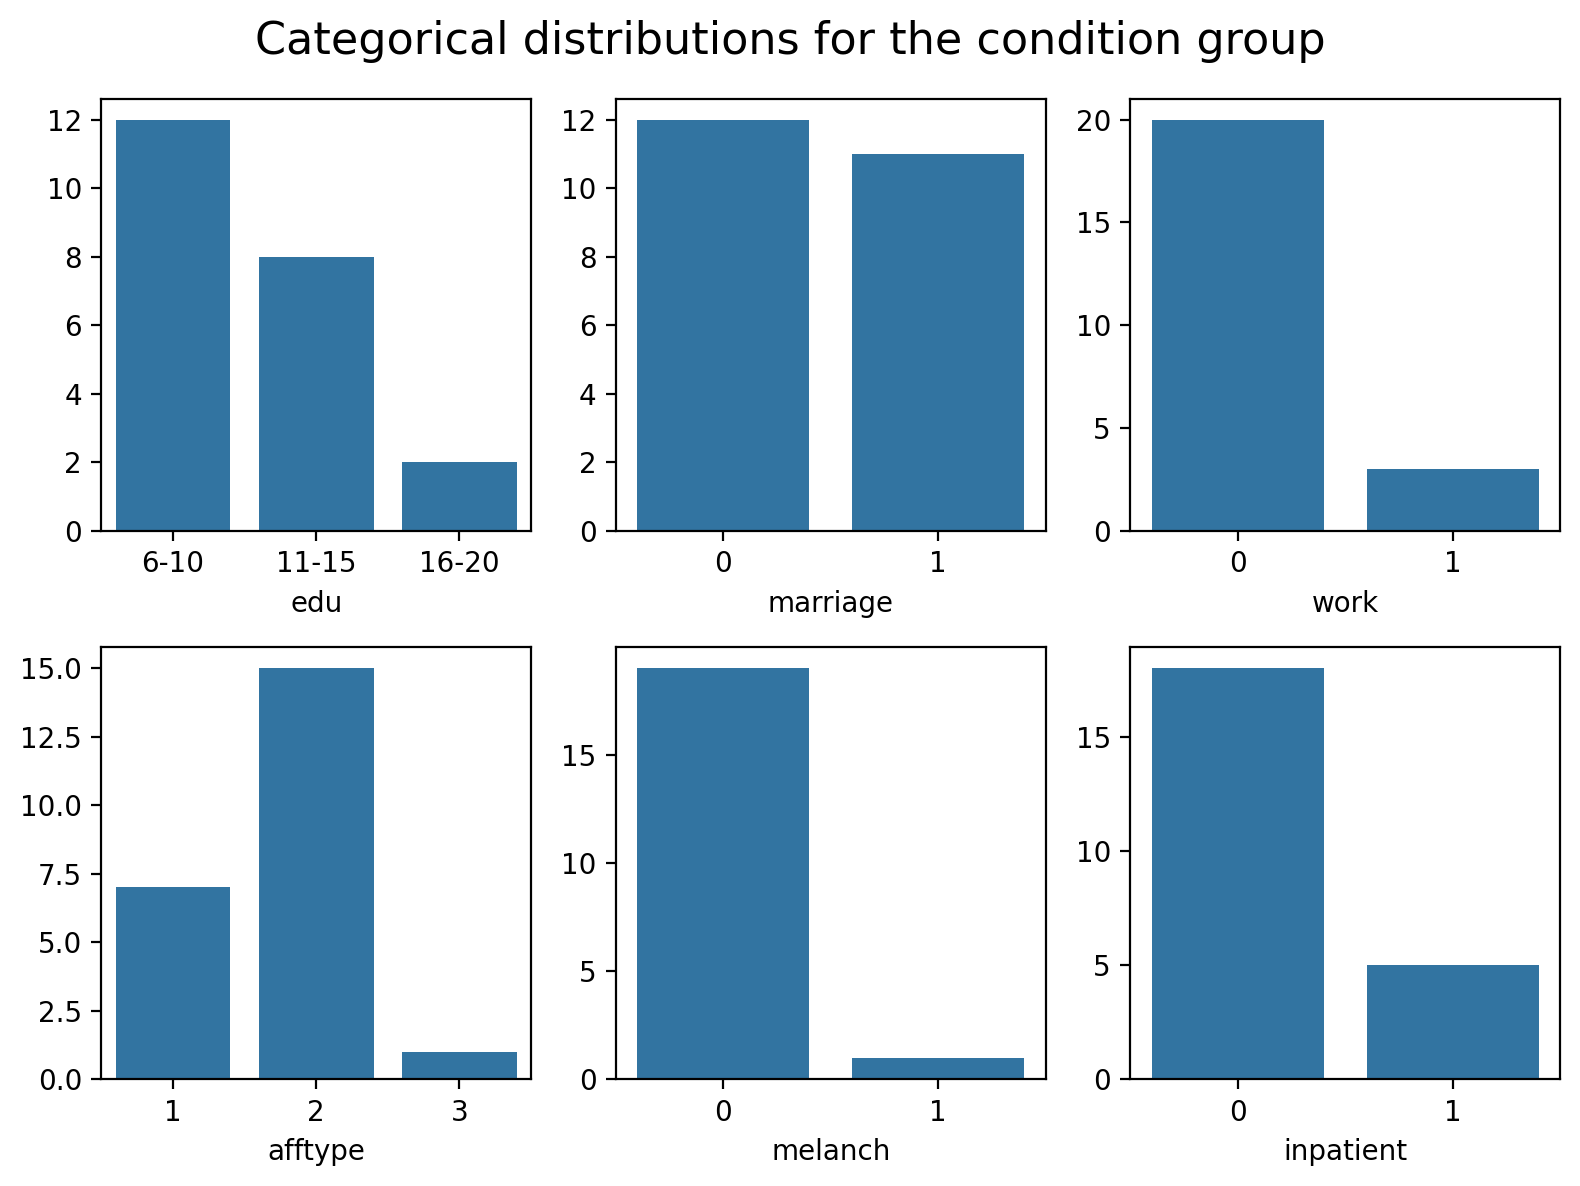

In [32]:
# Univariate distributions across the condition dataset

depressed = patients.query('condition == 1').copy()
categorical = ['edu', 'marriage', 'work', 'afftype', 'melanch', 'inpatient']

plt.figure(figsize=(8,6), dpi=200)
for i, cat in enumerate(categorical):
    plt.subplot(2,3,i+1)
    sns.countplot(data=depressed.dropna(subset=[cat]), x=cat)
    plt.ylabel('')

plt.suptitle('Categorical distributions for the condition group', fontsize=16)
plt.tight_layout()
plt.show()

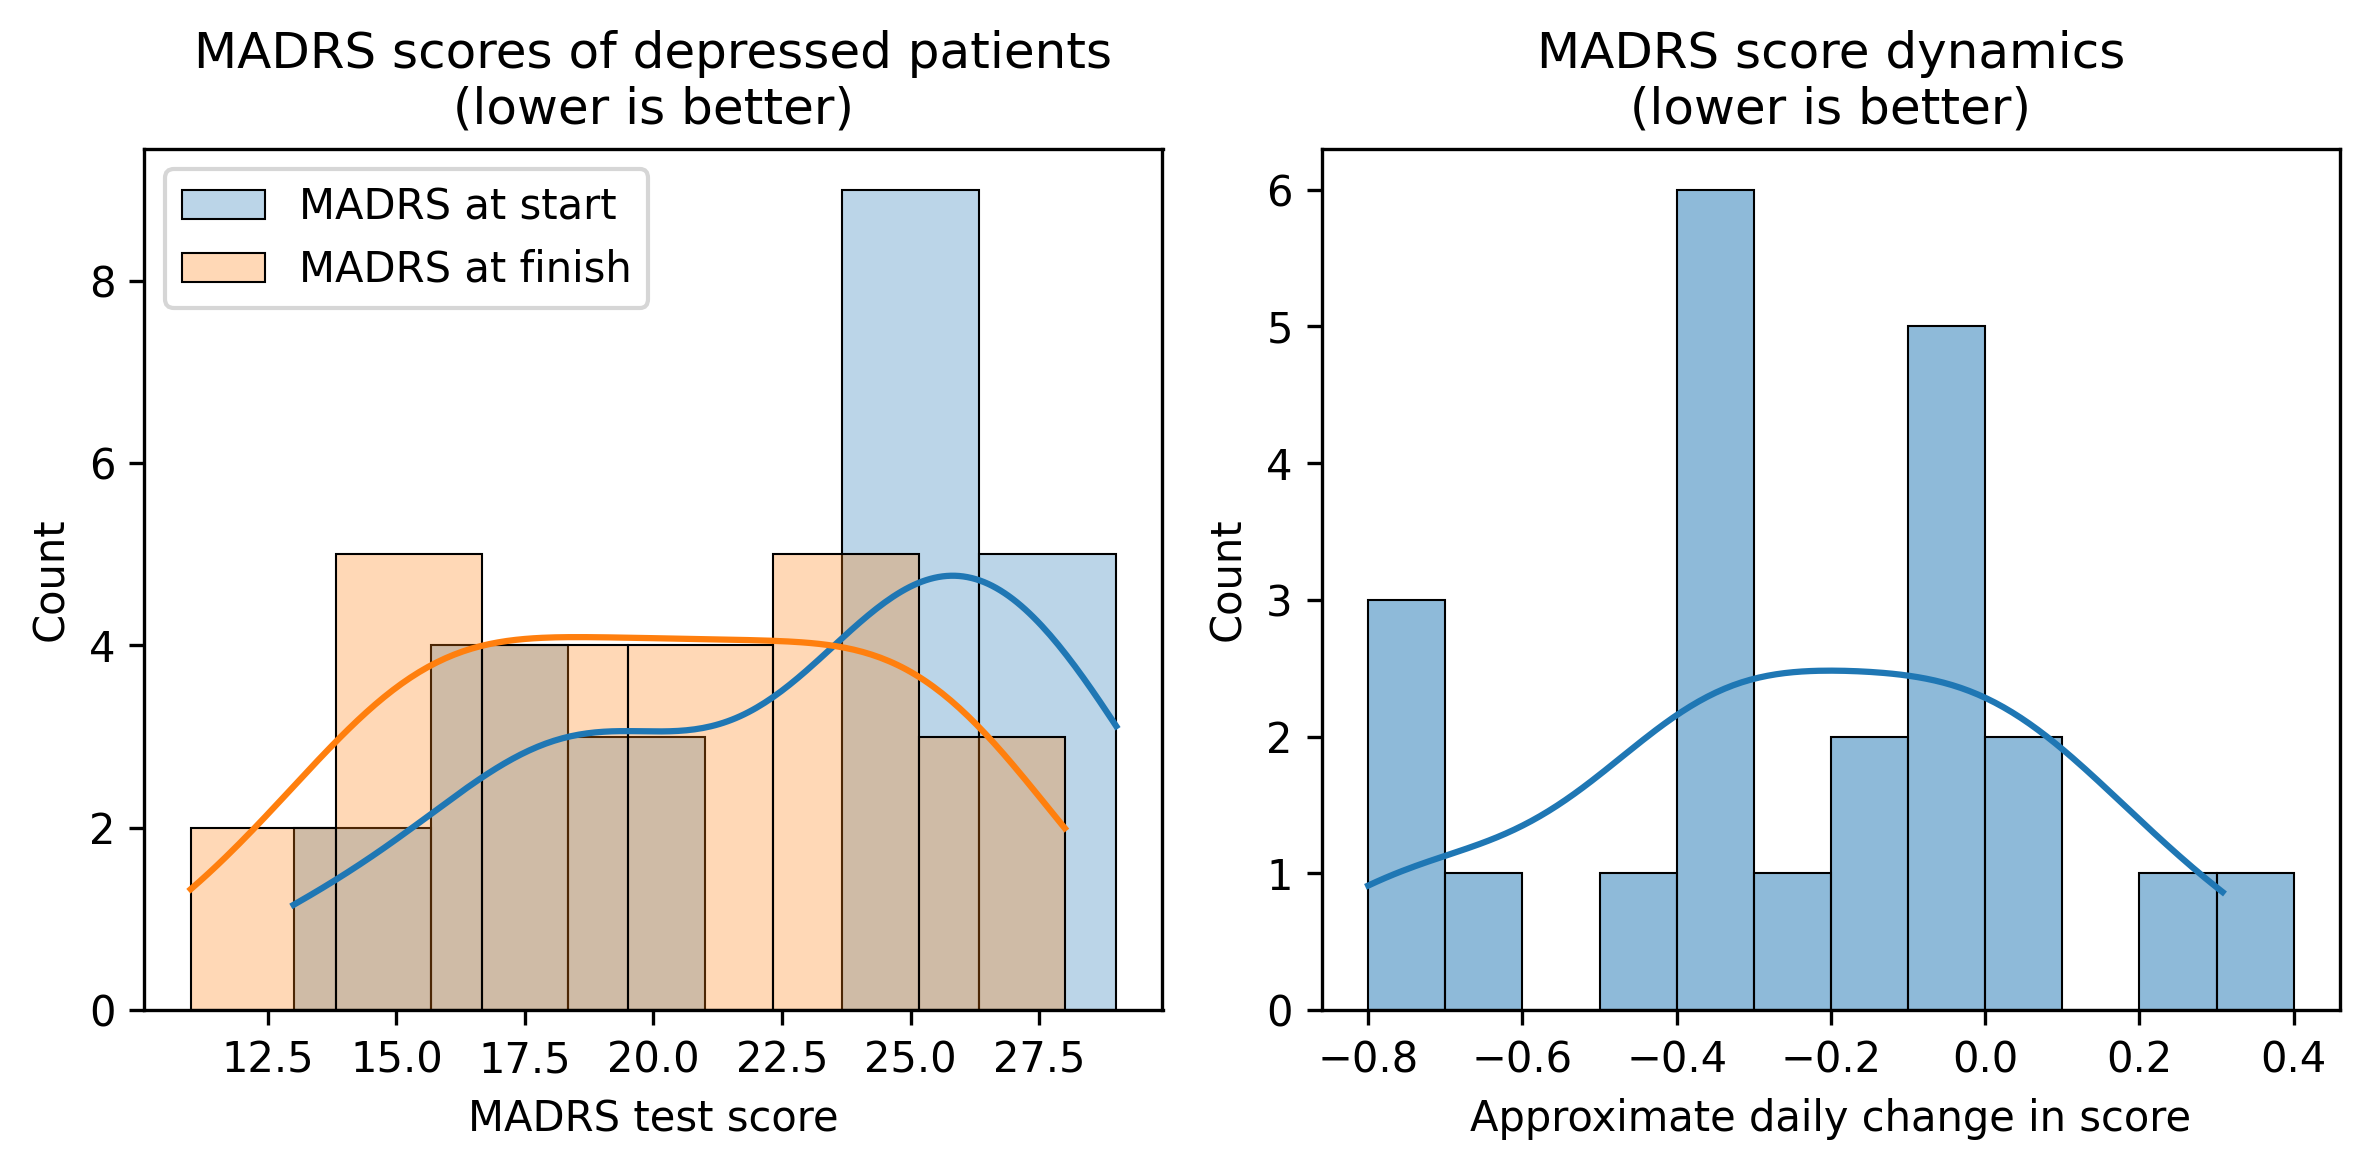

In [34]:
# MARDS dynamics

depressed['madrs_dynamic'] = (depressed.madrs2 - depressed.madrs1) / depressed.days

plt.figure(figsize=(8,4), dpi=300)
plt.subplot(1,2,1)
sns.histplot(data=depressed, x='madrs1', alpha=0.3, label='MADRS at start', kde=True)
sns.histplot(data=depressed, x='madrs2', alpha=0.3, label='MADRS at finish', kde=True)
plt.setp(plt.gca().patches, linewidth=0.5)
plt.xlabel('MADRS test score')
plt.title('MADRS scores of depressed patients\n(lower is better)')
plt.legend()

plt.subplot(1,2,2)
sns.histplot(data=depressed, x='madrs_dynamic', kde=True, bins=np.linspace(-0.8, 0.4, 13))
plt.setp(plt.gca().patches, linewidth=0.5)
plt.xlabel('Approximate daily change in score')
plt.title('MADRS score dynamics\n(lower is better)')

plt.tight_layout()
plt.show()

# Group-level observations

It appears the vast majority of patients are feeling better at the end of the study than at the beginning. Let's take a closer look at the activity of those that improved compared to activity of those that did not.

In [36]:
daily_activity = pd.DataFrame({
    'patient' : [],
    'time' : [],
    'activity' : []
})

for k in activity:
    patient_activity = activity[k]
    times = patient_activity.timestamp.dt.time
    activities = patient_activity.activity
    df = pd.DataFrame({
        'patient' : np.full(patient_activity.shape[0], k),
        'time' : patient_activity.timestamp.dt.time,
        'activity' : patient_activity.activity
    })
    daily_activity = pd.concat((daily_activity, df), axis=0)

daily_activity.info

<bound method DataFrame.info of             patient      time  activity
0      condition_23  13:00:00     161.0
1      condition_23  13:01:00      80.0
2      condition_23  13:02:00     175.0
3      condition_23  13:03:00     728.0
4      condition_23  13:04:00     911.0
...             ...       ...       ...
21055     control_8  23:55:00       0.0
21056     control_8  23:56:00       0.0
21057     control_8  23:57:00       0.0
21058     control_8  23:58:00       0.0
21059     control_8  23:59:00       0.0

[1210748 rows x 3 columns]>

In [37]:
agg_activity = daily_activity.groupby(['patient', 'time']).agg('mean').reset_index()
agg_activity = agg_activity.pivot(index='patient', columns='time', values='activity').reset_index()
agg_activity.head()

time       patient    00:00:00    00:01:00    00:02:00    00:03:00  \
0      condition_1   42.066667   89.266667   88.333333   47.866667   
1     condition_10   46.571429   74.571429   77.500000  101.285714   
2     condition_11  122.000000  116.625000   97.375000   98.437500   
3     condition_12   84.153846   97.384615  162.000000  184.692308   
4     condition_13  411.666667  492.800000  467.866667  367.066667   

time    00:04:00    00:05:00    00:06:00    00:07:00    00:08:00  ...  \
0      74.133333   67.400000   76.533333  121.133333  139.066667  ...   
1      80.214286   89.285714   69.357143    3.857143   10.642857  ...   
2      94.125000  143.625000  162.125000  155.125000  183.250000  ...   
3     151.384615  111.461538  144.923077   64.615385   60.076923  ...   
4     412.666667  252.600000  190.200000  167.000000  185.866667  ...   

time    23:50:00    23:51:00    23:52:00    23:53:00    23:54:00    23:55:00  \
0      38.187500   21.875000   23.875000   42.250000   31.187500   20.875000   
1      51.266667   56.066667   92.066667  131.733333   62.600000   30.866667   
2     246.937500  212.187500  164.125000  173.187500  107.500000   90.812500   
3      90.571429  145.285714  118.857143  143.857143   95.714286  136.857143   
4     255.562500  291.437500  248.437500  304.125000  380.000000  359.250000   

time    23:56:00    23:57:00    23:58:00    23:59:00  
0      11.812500   23.937500   57.625000   24.250000  
1      25.200000    8.600000   58.533333   40.666667  
2     130.312500  159.250000   97.500000  117.187500  
3      77.285714  155.357143   93.928571   88.214286  
4     351.312500  442.312500  401.625000  354.625000  

[5 rows x 1441 columns]

In [243]:
import datetime

def get_label(patient):
    if patient.startswith('control'):
        label = 'control'
    else:
        dynamic = depressed.loc[patient, 'madrs_dynamic']
        if dynamic <= 0.0:
            label = 'improving'
        # elif dynamic <= 0:
        #     label = 'stable' 
        else:
            label = 'getting worse'
    return label

def is_condition(patient):
    return int(patient.startswith('condition'))

# def time_of_day(time):
#     out = None
#     if time < datetime.time(6, 0):
#         out = 'night'
#     elif time < datetime.time(12,0):
#         out = 'morning'
#     elif time < datetime.time(18, 0):
#         out = 'afternoon'
#     else:
#         out = 'evening'
#     return out

start_time = datetime.time(0,0)
end_time = datetime.time(23,59)
morning = datetime.time(6,0)
afternoon = datetime.time(12,0)
evening = datetime.time(18,0)

agg_activity['label'] = agg_activity.patient.map(get_label)
agg_activity['mean_activity_total'] = agg_activity.loc[:, start_time:end_time].mean(axis=1)
agg_activity['mean_activity_night'] = agg_activity.loc[:, start_time:morning].mean(axis=1)
agg_activity['mean_activity_morning'] = agg_activity.loc[:, morning:afternoon].mean(axis=1)
agg_activity['mean_activity_afternoon'] = agg_activity.loc[:, afternoon:evening].mean(axis=1)
agg_activity['mean_activity_evening'] = agg_activity.loc[:, evening:end_time].mean(axis=1)
agg_activity['condition'] = agg_activity.patient.map(is_condition)
agg_activity['gender'] = patients['gender'][agg_activity.patient].values.map({0:'male', 1:'female'})

agg_activity.head()
# patients['gender'][['control_2']].values

time       patient    00:00:00    00:01:00    00:02:00    00:03:00  \
0      condition_1   42.066667   89.266667   88.333333   47.866667   
1     condition_10   46.571429   74.571429   77.500000  101.285714   
2     condition_11  122.000000  116.625000   97.375000   98.437500   
3     condition_12   84.153846   97.384615  162.000000  184.692308   
4     condition_13  411.666667  492.800000  467.866667  367.066667   

time    00:04:00    00:05:00    00:06:00    00:07:00    00:08:00  ...  \
0      74.133333   67.400000   76.533333  121.133333  139.066667  ...   
1      80.214286   89.285714   69.357143    3.857143   10.642857  ...   
2      94.125000  143.625000  162.125000  155.125000  183.250000  ...   
3     151.384615  111.461538  144.923077   64.615385   60.076923  ...   
4     412.666667  252.600000  190.200000  167.000000  185.866667  ...   

time    23:58:00    23:59:00      label  mean_activity_total  condition  \
0      57.625000   24.250000  improving           150.542549          1   
1      58.533333   40.666667  improving           290.578634          1   
2      97.500000  117.187500  improving           129.160897          1   
3      93.928571   88.214286  improving           166.562206          1   
4     401.625000  354.625000  improving           251.219789          1   

time  mean_activity_night  mean_activity_morning  mean_activity_afternoon  \
0               15.891597             138.965547               305.228012   
1               22.020776             303.419245               480.772299   
2               55.331371              49.113931               235.260561   
3               37.228212             106.671486               304.456668   
4               91.151801             278.504432               359.096607   

time  mean_activity_evening  gender  
0                142.653299    male  
1                356.838519    male  
2                177.204514  female  
3                218.006746    male  
4                276.080556    male  

[5 rows x 1449 columns]

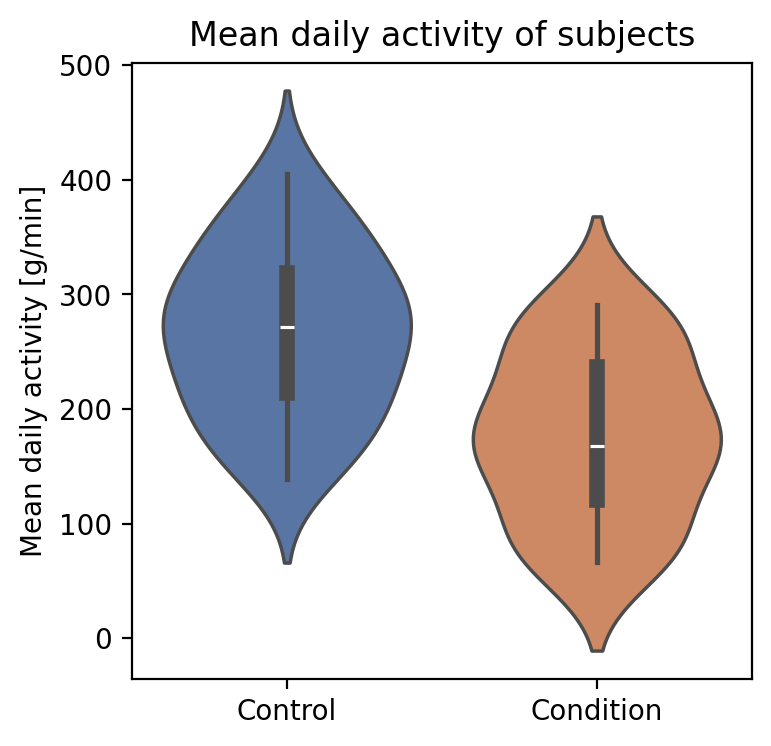

In [133]:
condition_palette = sns.color_palette('deep')[:2]
plt.figure(figsize=(4,4), dpi=200)
sns.violinplot(data=agg_activity, x='condition', y='mean_activity_total', hue='condition', palette=condition_palette, legend=False)
plt.xticks([0,1], ['Control', 'Condition'])
plt.xlabel('')
plt.ylabel('Mean daily activity [g/min]')
plt.title('Mean daily activity of subjects', fontsize=12)
plt.show()

In [110]:
import scipy.stats as stats

control = agg_activity.query('condition == 0').mean_activity_total
condition = agg_activity.query('condition == 1').mean_activity_total
stats.ttest_ind(control, condition)

TtestResult(statistic=4.510826883750849, pvalue=3.615379320436397e-05, df=53.0)

In [83]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

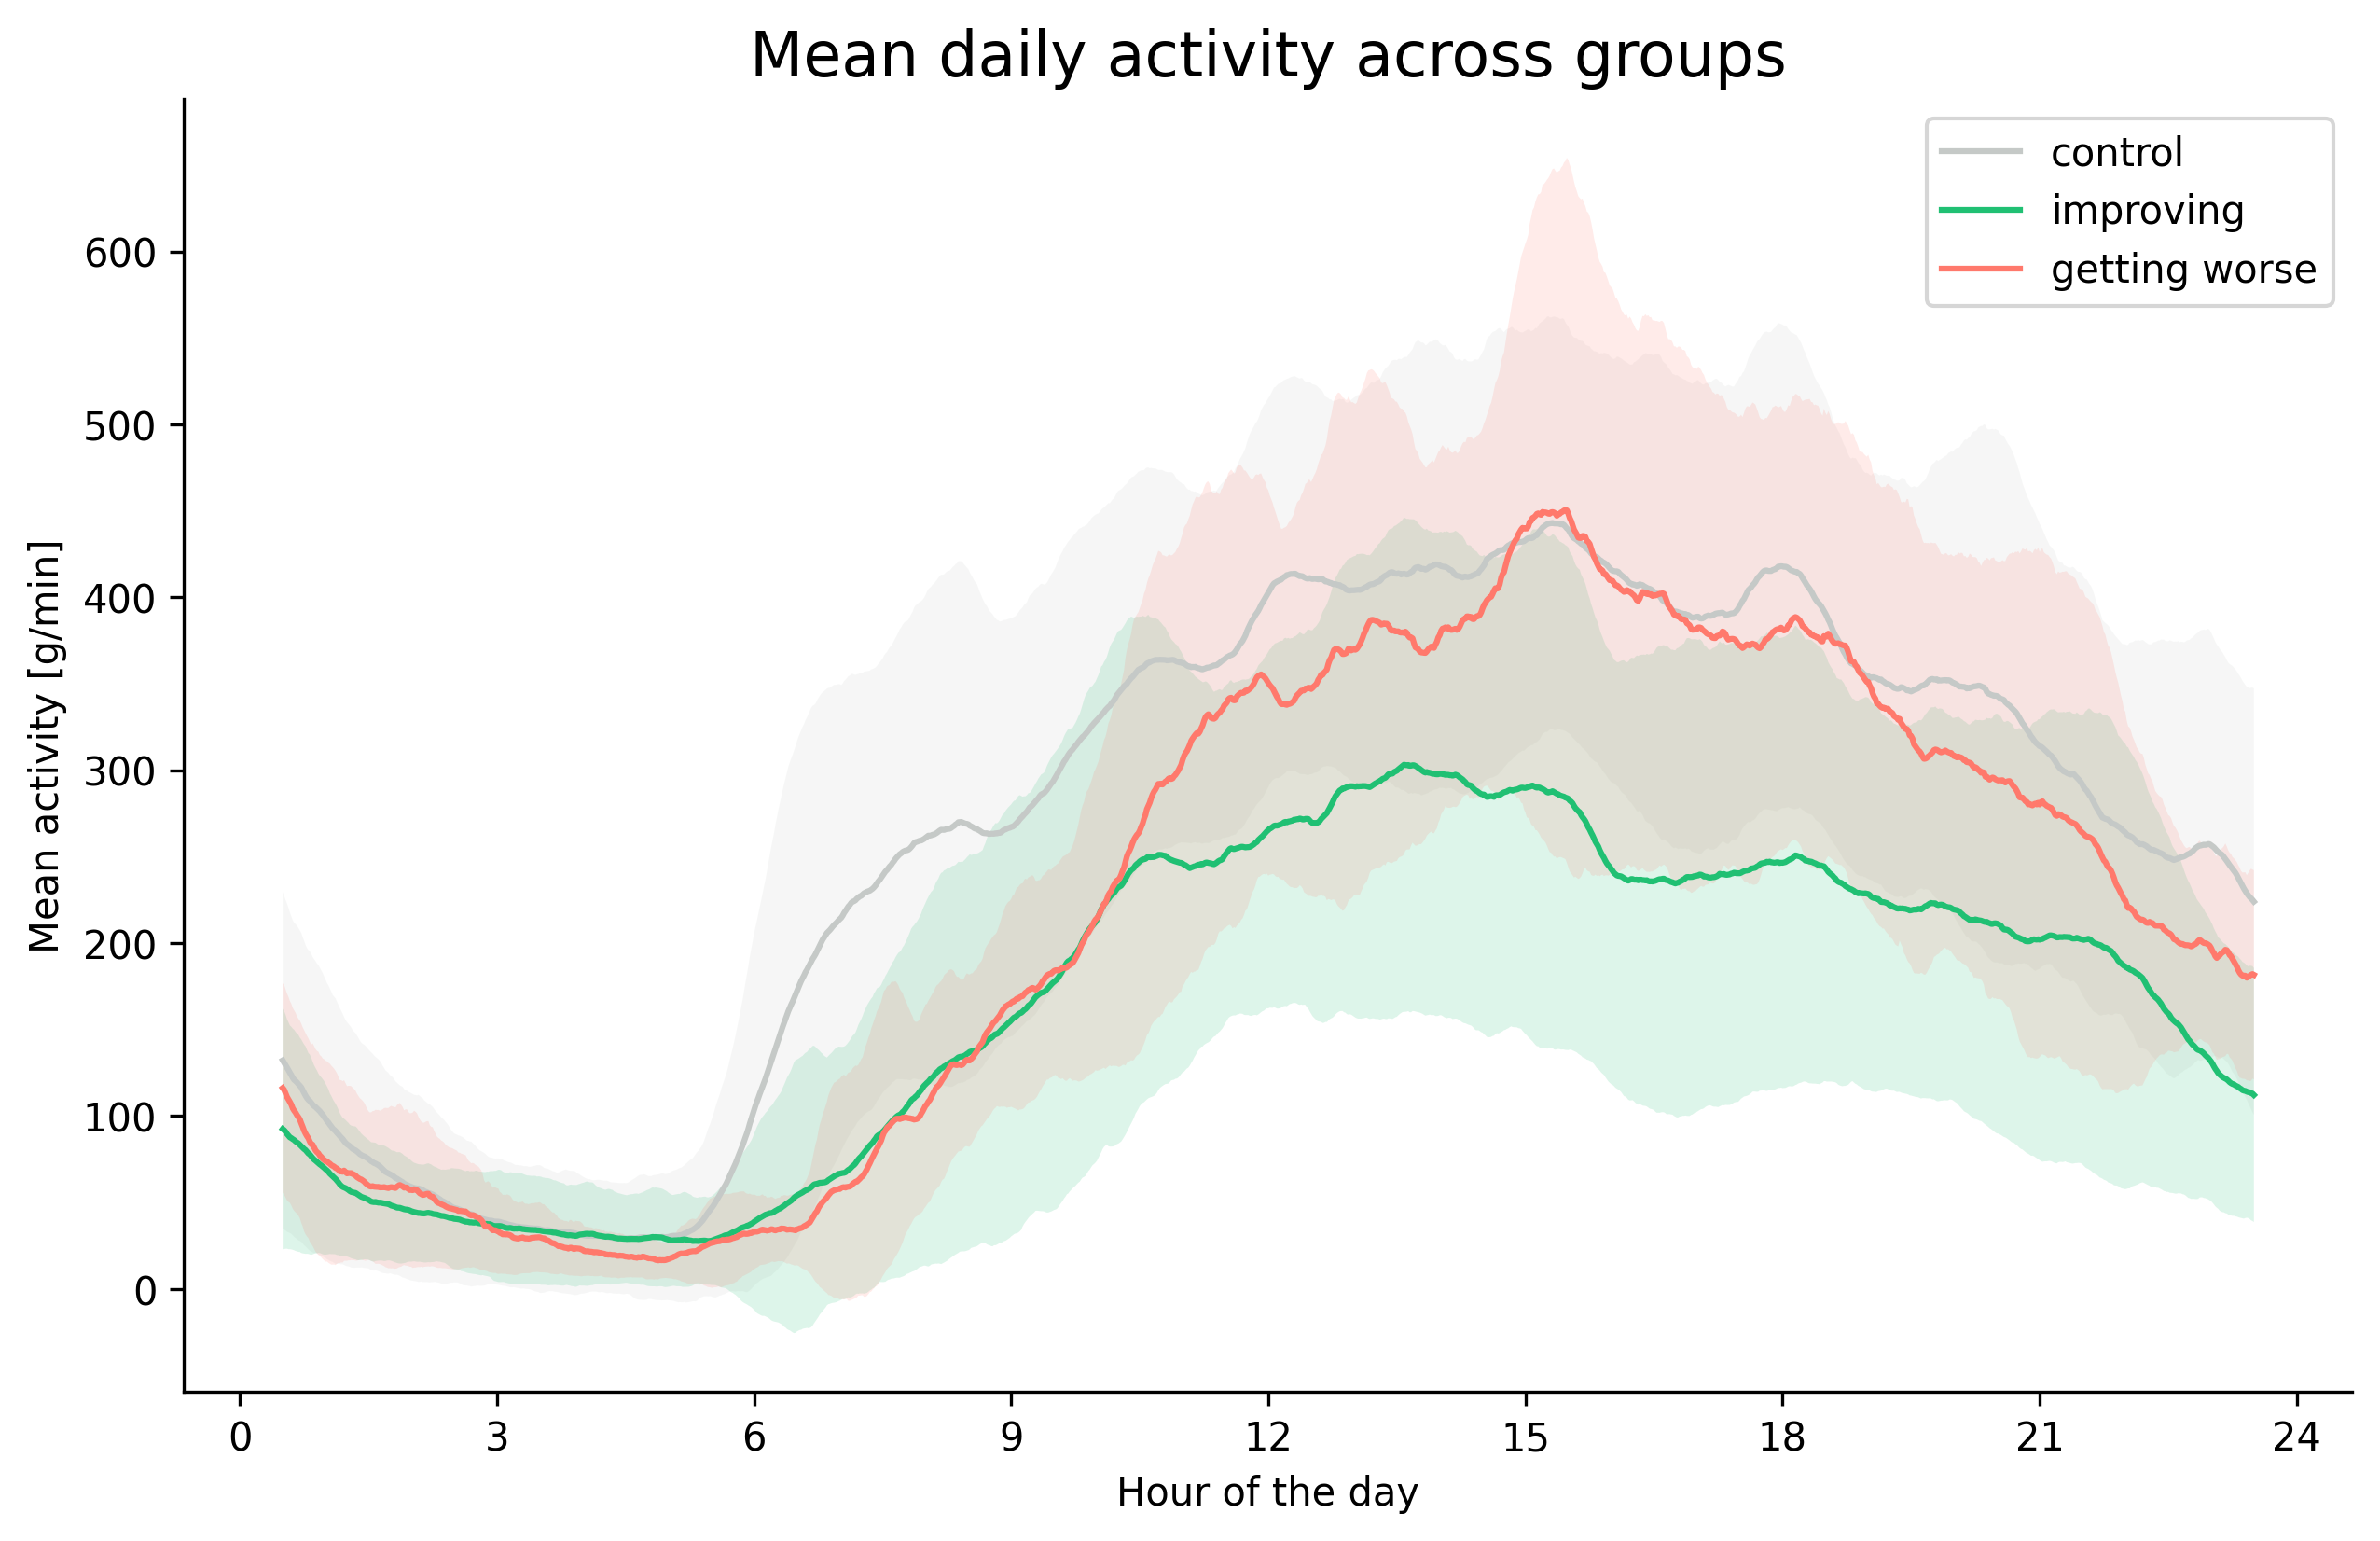

In [251]:
X = agg_activity.loc[:, start_time:end_time].to_numpy()
groups = ['control', 'improving', 'getting worse']
window = 60

color_dict = {
    'control' : 'xkcd:silver',
    'improving' : 'xkcd:dark mint green',
    # 'stable' : 'xkcd:denim',
    'getting worse' : 'xkcd:salmon'
}
alpha_dict = {
    'control' : 0.2,
    'improving' : 0.3,
    # 'stable' : 0.5,
    'getting worse' : 1.0
}
colors = agg_activity.label.map(color_dict)
alphas = agg_activity.label.map(alpha_dict)
labels = agg_activity.label

plt.figure(figsize=(10,6), dpi=300)
for group in groups:
    group_activity = agg_activity.query(f"label == '{group}'").loc[:, start_time:end_time].apply(
        lambda row: moving_average(row, window),
        axis=1
    ).to_numpy()
    activity_mean = group_activity.mean()
    activity_std = group_activity.std()
    plt.plot(
        range(1440)[(window//2):-(window//2)+1], 
        activity_mean, 
        color=color_dict[group], 
        linewidth=1.5, 
        label=group)
    plt.fill_between(
        range(1440)[(window//2):-(window//2)+1], 
        activity_mean - activity_std, 
        activity_mean + activity_std, 
        facecolor=color_dict[group], 
        alpha=0.15)


# plt.plot(range(1440), mean_control, color=color_dict['control'], linewidth=1.0, label='control')
# plt.plot(range(1440), mean_improving, color=color_dict['improving'], linewidth=1.0, label='improving')
# plt.plot(range(1440), mean_getting_worse, color=color_dict['getting worse'], linewidth=1.0, label='getting worse')
plt.xticks(np.linspace(0, 1440, 9), np.linspace(0, 24, 9).astype(int))
plt.xlabel('Hour of the day')
plt.ylabel('Mean activity [g/min]')
plt.title('Mean daily activity across groups', fontsize=16)
plt.legend()

ax = plt.gca() 
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

Curious, it appears the patients whose condition is worsening act similar to the patients with depression during the first half of the day, but become more active in the afternoon, almost matching be behavior of the control group after 11 am.

Let's also examine a similar plot with female patients only.

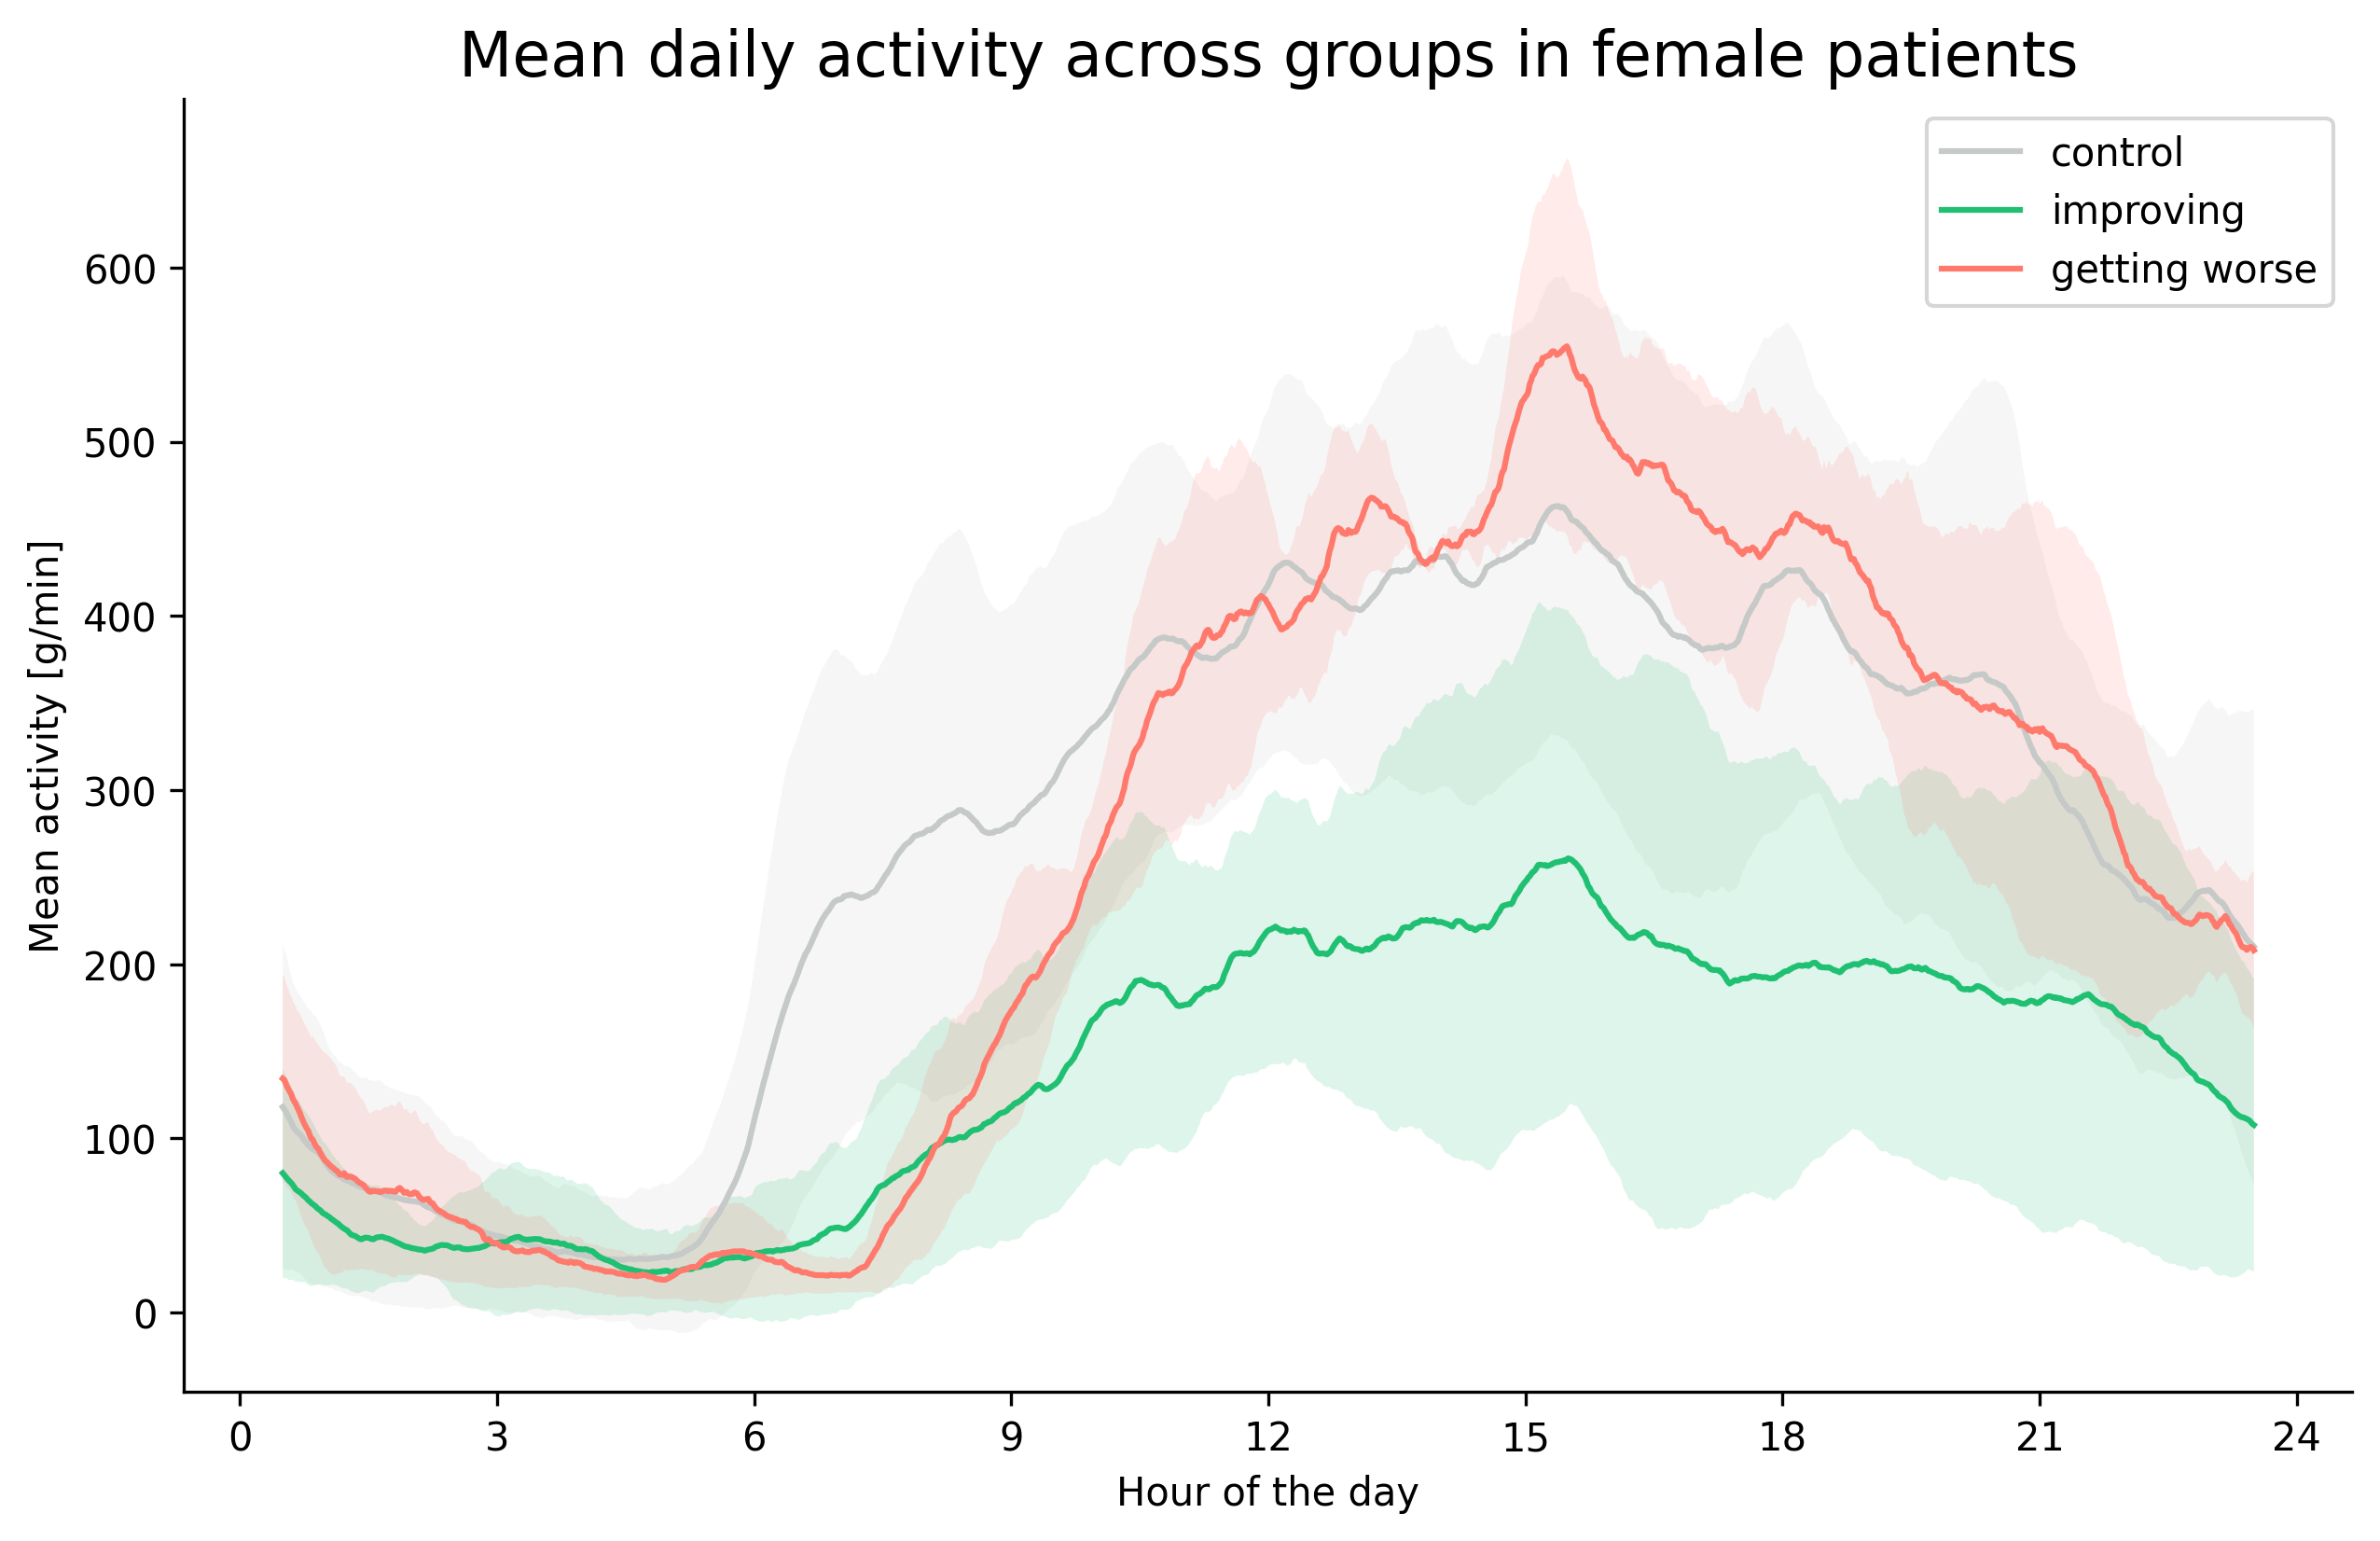

In [235]:
female_patients = patients.query('gender == 1').index
agg_activity_female = agg_activity.query('patient in @female_patients')

groups = ['control', 'improving', 'getting worse']

plt.figure(figsize=(10,5), dpi=300)
for group in groups:
    group_activity = agg_activity_female.query(f"label == '{group}'").loc[:, start_time:end_time].apply(
        lambda row: moving_average(row, window),
        axis=1
    ).to_numpy()
    activity_mean = group_activity.mean()
    activity_std = group_activity.std()
    plt.plot(
        range(1440)[(window//2):-(window//2)+1], 
        activity_mean, 
        color=color_dict[group], 
        linewidth=1.5, 
        label=group)
    plt.fill_between(
        range(1440)[(window//2):-(window//2)+1], 
        activity_mean - activity_std, 
        activity_mean + activity_std, 
        facecolor=color_dict[group], 
        alpha=0.15)


# plt.plot(range(1440), mean_control, color=color_dict['control'], linewidth=1.0, label='control')
# plt.plot(range(1440), mean_improving, color=color_dict['improving'], linewidth=1.0, label='improving')
# plt.plot(range(1440), mean_getting_worse, color=color_dict['getting worse'], linewidth=1.0, label='getting worse')
plt.xticks(np.linspace(0, 1440, 9), np.linspace(0, 24, 9).astype(int))
plt.xlabel('Hour of the day')
plt.ylabel('Mean activity [g/min]')
plt.title('Mean daily activity across groups in female patients', fontsize=16)
plt.legend()

ax = plt.gca() 
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

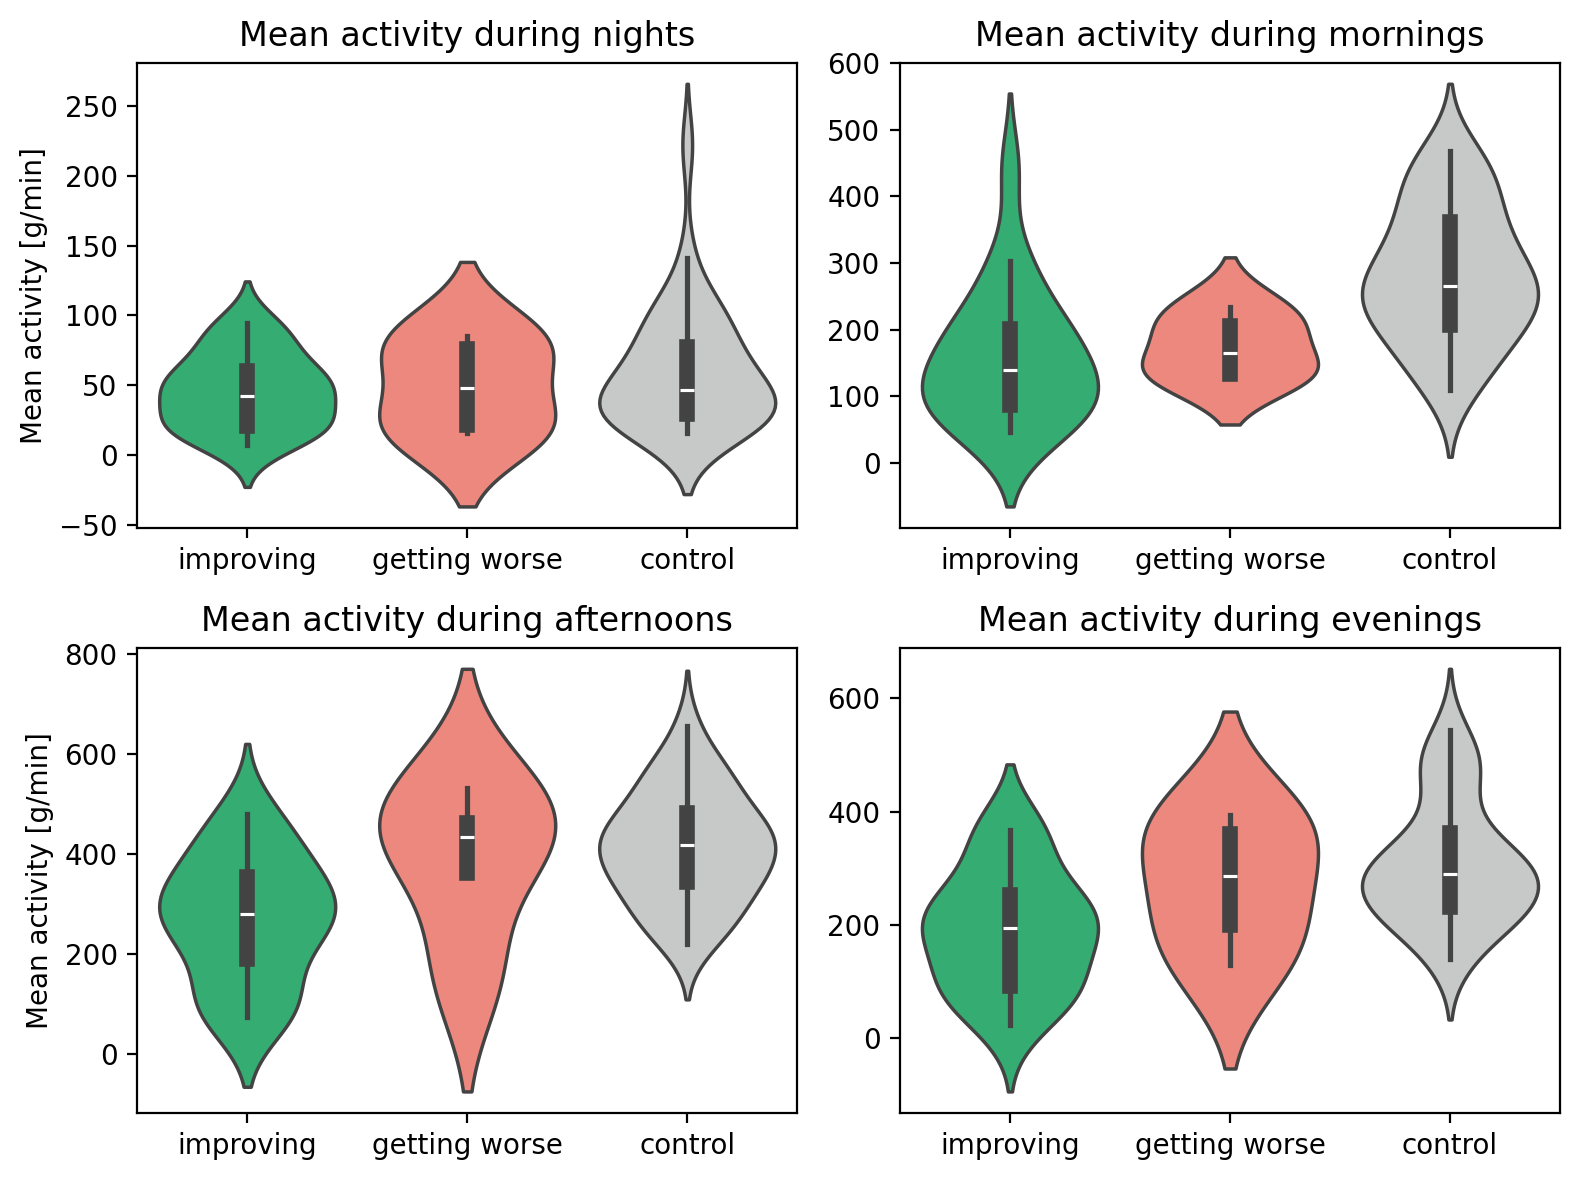

In [230]:
labels_violin = ['improving', 'getting worse', 'control']
condition_palette = [color_dict[l] for l in labels_violin]
times_of_day = ['night', 'morning', 'afternoon', 'evening']

plt.figure(figsize=(8,6), dpi=200)
for i, tod in enumerate(times_of_day):
    plt.subplot(2,2,i+1)
    sns.violinplot(
        data=agg_activity, 
        x='label', 
        y=f'mean_activity_{tod}', 
        hue='label', 
        palette=condition_palette, 
        legend=False)
    plt.xlabel('')
    if i % 2 == 0:
        plt.ylabel('Mean activity [g/min]')
    else:
        plt.ylabel('')
    plt.title(f'Mean activity during {tod}s', fontsize=12)
plt.tight_layout()
plt.show()

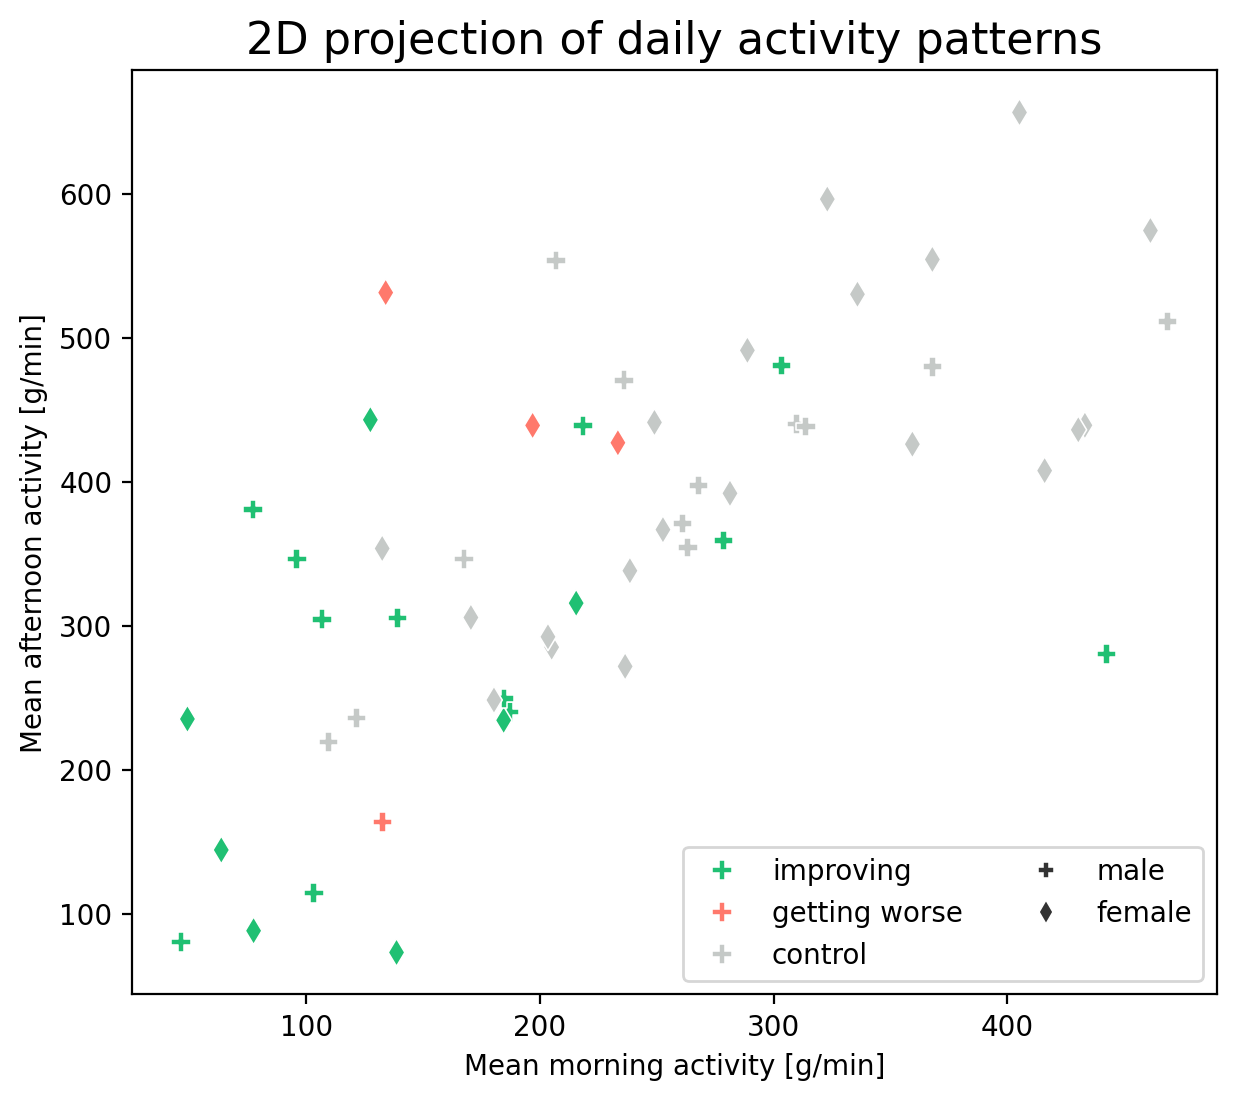

In [249]:
plt.figure(figsize=(7,6), dpi=200)
ax = sns.scatterplot(
    data=agg_activity, 
    x='mean_activity_morning', 
    y='mean_activity_afternoon', 
    hue='label', 
    style='gender',
    markers = ['P', 'd'],
    size='label',
    sizes=[50, 50, 50],
    palette=condition_palette
)
handles, labels = ax.get_legend_handles_labels()
handles = handles[1:4] + handles[5:]
labels = labels[1:4] + labels[5:]
ax.legend(handles=handles, labels=labels, ncol=2, loc='lower right')
plt.xlabel('Mean morning activity [g/min]')
plt.ylabel('Mean afternoon activity [g/min]')
plt.title('2D projection of daily activity patterns', fontsize=16)
plt.show()

## Subject-level investigation

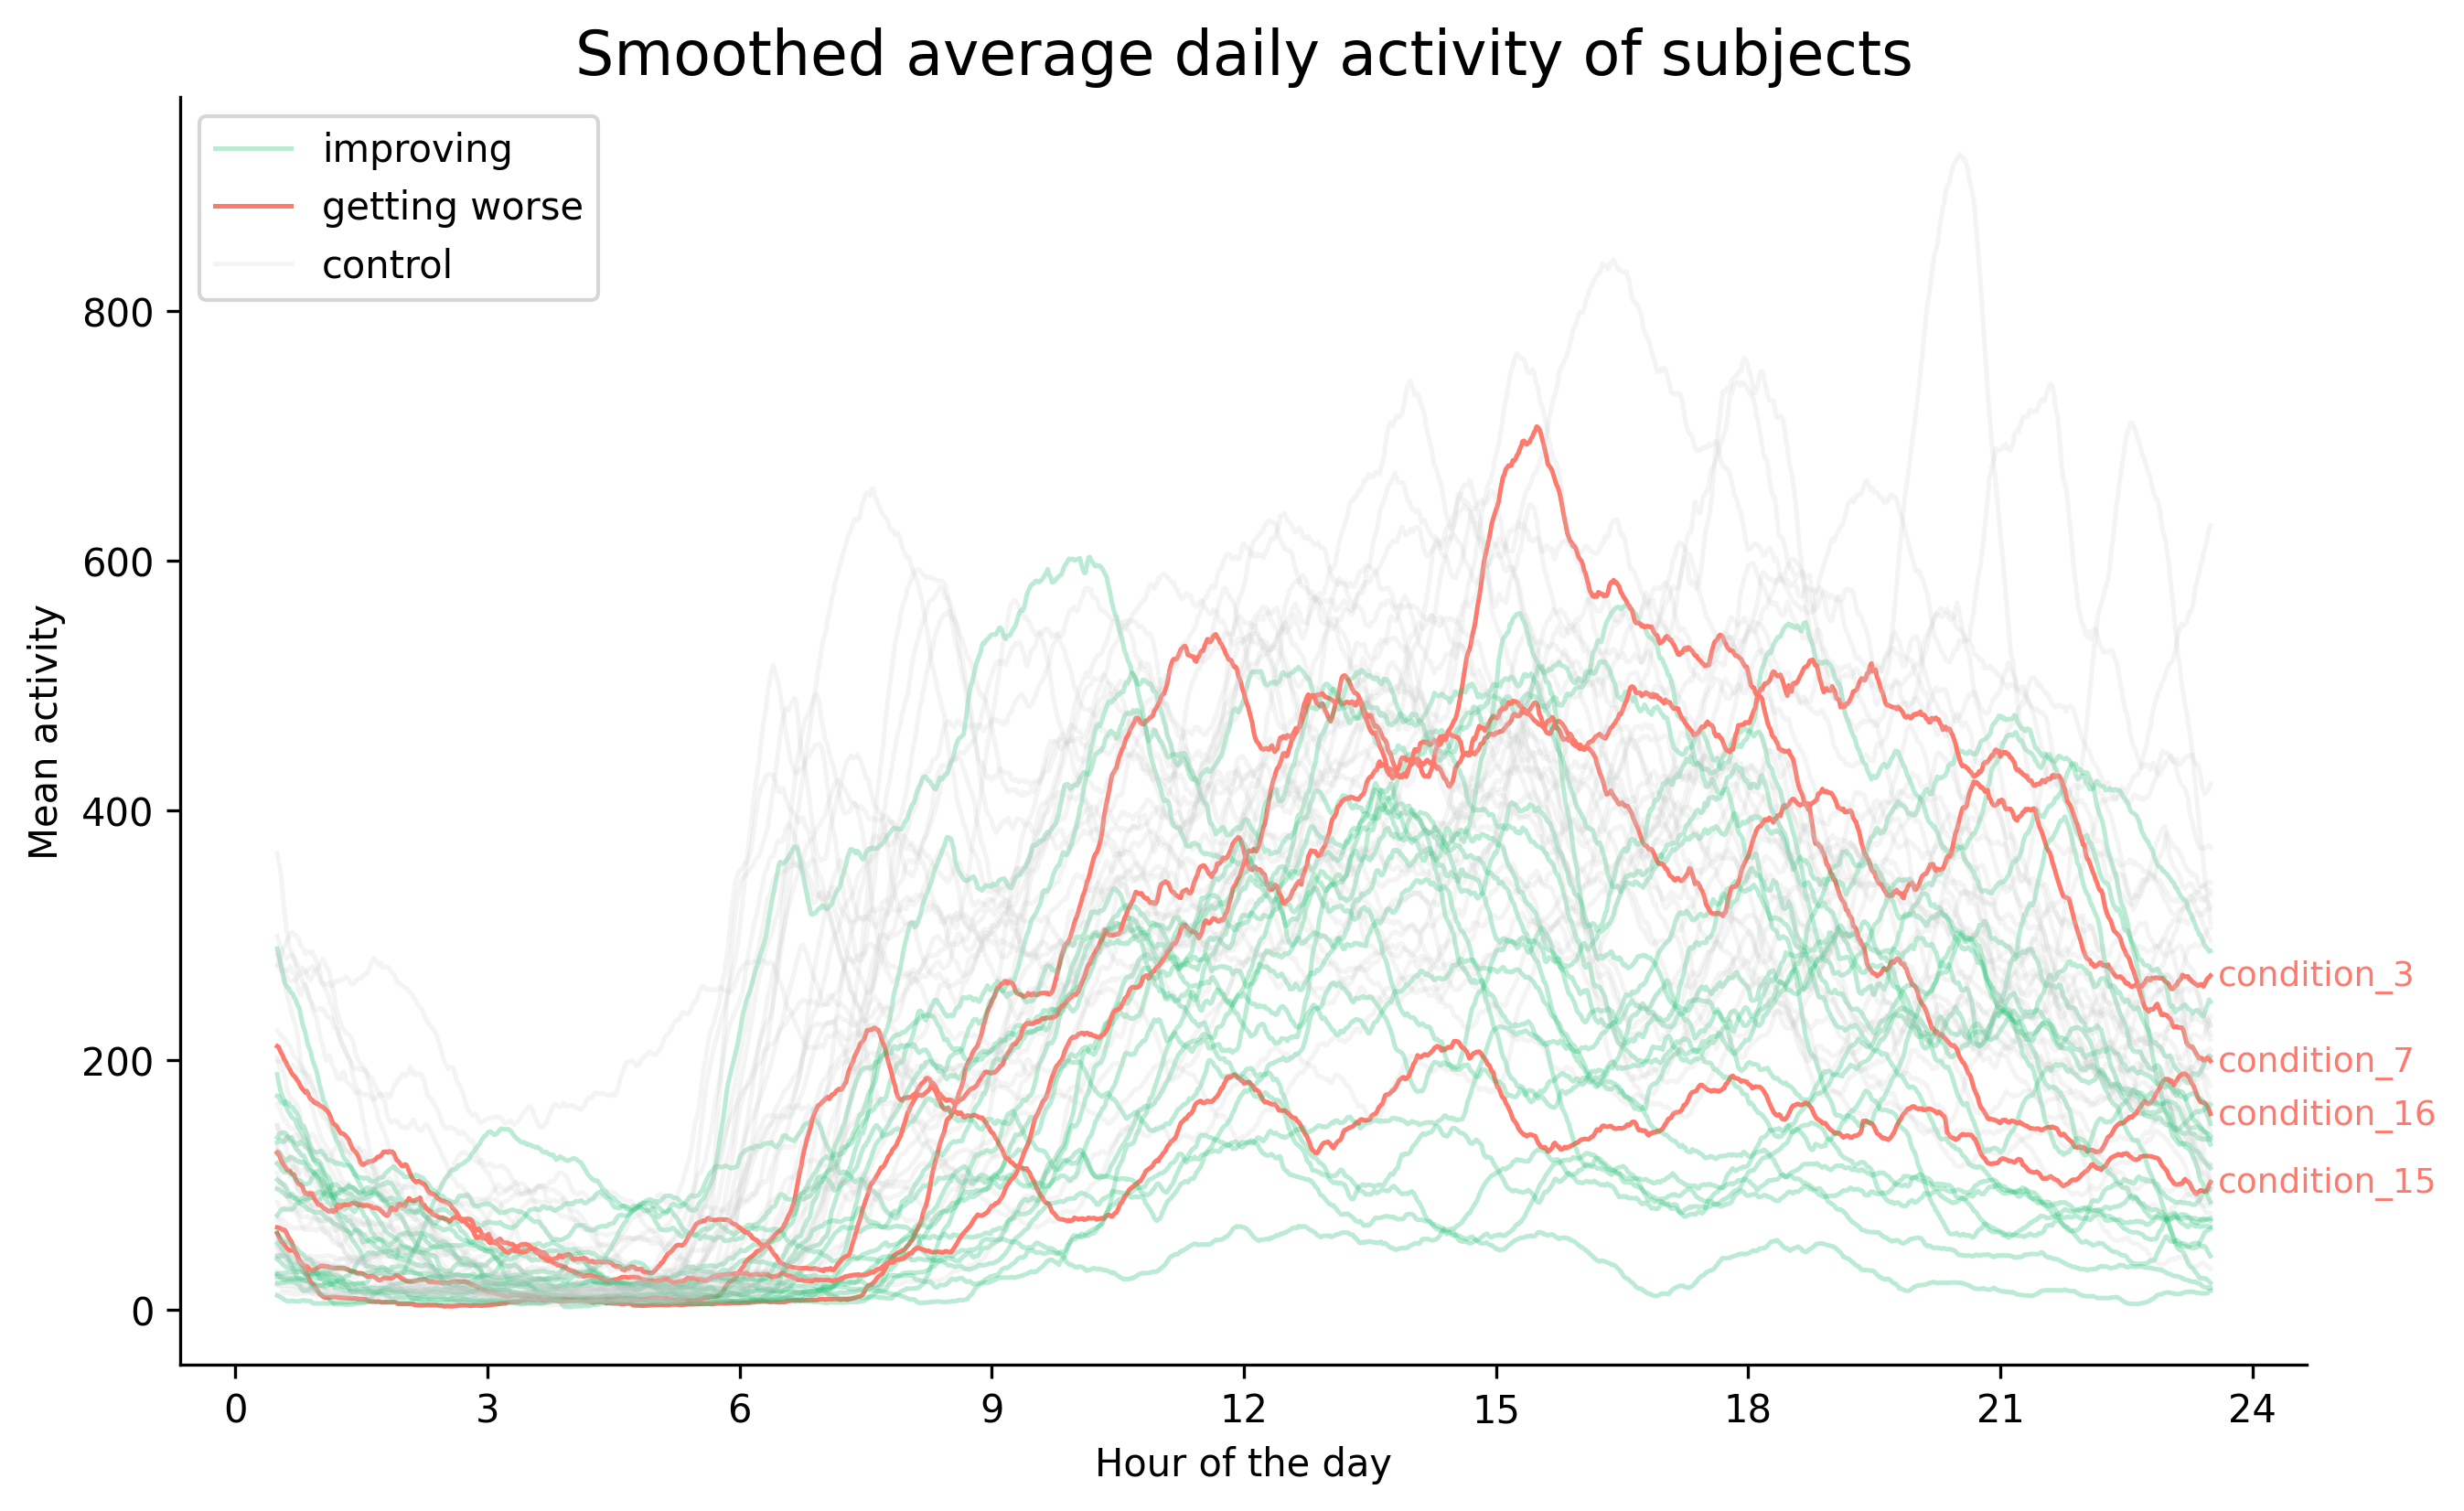

In [252]:
plt.figure(figsize=(10,6), dpi=300)
for i in range(agg_activity.shape[0]):
    y = moving_average(X[i,:], window)
    plt.plot(range(1440)[(window//2):-(window//2)+1], y, color=colors[i], alpha=alphas[i], linewidth=1.2, label=labels[i])
    if labels[i] == 'getting worse':
        xoffset = 5
        yoffset = -8
        plt.text(1440-window//2+xoffset, y[-1]+yoffset, agg_activity.patient[i], color=colors[i], fontsize=9)
plt.xticks(np.linspace(0, 1440, 9), np.linspace(0, 24, 9).astype(int))
plt.xlabel('Hour of the day')
plt.ylabel('Mean activity')
plt.title('Smoothed average daily activity of subjects', fontsize=16)

ax = plt.gca()                     
a = ax.get_legend_handles_labels()  
b = {l:h for h,l in zip(*a)}        
c = [*zip(*b.items())]             
d = c[::-1]                        
plt.legend(*d)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

Let's take a closer look at the four subjects whose condition has worsened.

In [593]:
worsenening_patients = agg_activity.query(f"label == 'getting worse'").patient
patients.loc[worsenening_patients]

days  gender    age  afftype  melanch  inpatient    edu  \
number                                                                  
condition_15    13       0  55-59        2        0          0  11-15   
condition_16    16       1  45-49        2        0          0  11-15   
condition_3     13       1  45-49        2        0          0   6-10   
condition_7     11       1  20-24        1     <NA>          0  11-15   

              marriage  work  madrs1  madrs2  condition  
number                                                   
condition_15         1     1    14.0    18.0          1  
condition_16         1     0    13.0    17.0          1  
condition_3          0     0    24.0    25.0          1  
condition_7          0     1    24.0    25.0          1